In [904]:

# ====================================================
# Library
# ====================================================
import sys
import os
import gc
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')
import random
import copy
import scipy as sp
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import joblib
import pickle
import itertools
from tqdm.auto import tqdm
import category_encoders as ce
import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import Callback
from keras.models import clone_model
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100)

# ====================================================
# Configurations
# ====================================================
class CFG:
    VER = 19
    AUTHOR = 'Yuta.K'
    COMPETITION = 'SC2024'
    DATA_PATH = Path('/data')
    OOF_DATA_PATH = Path('/oof')
    MODEL_DATA_PATH = Path('/models')
    SUB_DATA_PATH = Path('/submission')
    METHOD_LIST = [
        # 'adaboost','lightgbm','xgboost',
                   'catboost']
    # seed 42
    # seed 15 25 35 45 55
    seed = 55
    n_folds = 7
    target_col = 'ProdTaken'
    metric = 'AUC'
    metric_maximize_flag = True
    num_boost_round = 300
    early_stopping_round = 100
    verbose = 100
    classification_lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves' : 15,
        'lambda_l1' : 0.2,
        'lambda_l2' : 0.2,
        'seed': seed,
    }
    classification_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'lambda':2,
        'random_state': seed,
    }

    classification_cat_params = {
        'learning_rate': 0.25,
        # 'eval_metric': 'AUC',
        'depth':1,
        'l2_leaf_reg' : 6,
        'iterations':1000,
        'random_seed': seed,
        'one_hot_max_size' : 25,
    }
    classification_adaboost_params = {
        'n_estimators': 100,
        'learning_rate': 1.0,
        'random_state': 42,
    }
    
    model_weight_dict = {
        # 'adaboost': 0.06,'lightgbm': 0.2, 'xgboost': 0.04, 
                         'catboost': 1}
    
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)


# ====================================================
# Metric
# ====================================================
# AUC

#データの読み込み
train_df = pd.read_csv('dataset/train_processed.csv', index_col=0)
test_df = pd.read_csv('dataset/test_processed.csv', index_col=0)
test0 = pd.read_csv('dataset/test.csv', index_col=0)

In [905]:
train_df.columns

Index(['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation',
       'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'Married',
       'CarPossesion', 'NumberOfOffspring', 'Single',
       'NumberOfFollowups > NumberOfPersonVisiting',
       'ProductPitched_Designation', 'Income / child', 'MoneyforOneTrip',
       'AllOfcontact', 'NumberOfPersonVisiting - NumberOfOffspring',
       'ProdTaken'],
      dtype='object')

numerical_features ['Age', 'DurationOfPitch', 'MonthlyIncome', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring', 'Income / child', 'MoneyforOneTrip', 'AllOfcontact', 'NumberOfPersonVisiting - NumberOfOffspring']
categorical_features ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Married', 'CarPossesion', 'Single', 'NumberOfFollowups > NumberOfPersonVisiting', 'ProductPitched_Designation', 'ProdTaken']
features for training:['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarPossesion', 'NumberOfOffspring', 'Single', 'NumberOfFollowups > NumberOfPersonVisiting', 'ProductPitched_Designation', 'Income / child', 'MoneyforOneTrip', 'AllOfcontact', 'NumberOfPersonVisiting - N

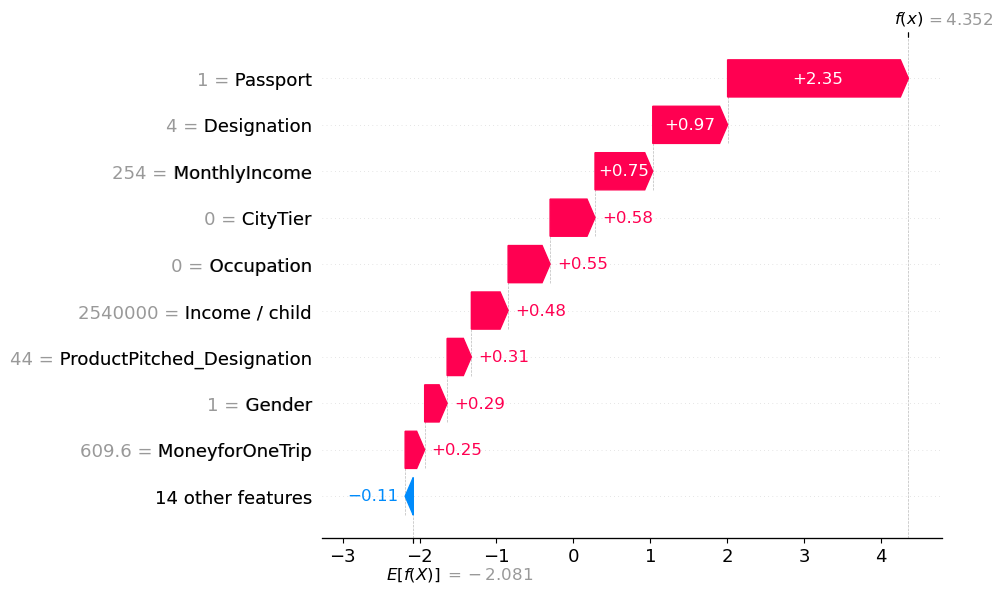

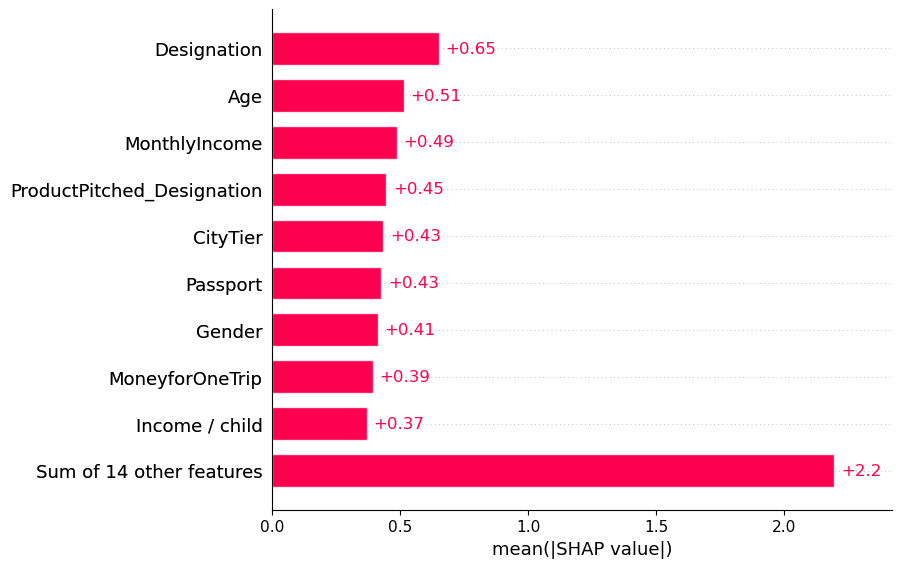

In [906]:
#学習に必要となるリストの作成
default_categorical_features = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Married', 'CarPossesion']
default_numerical_features = ['Age', 'DurationOfPitch', 'MonthlyIncome', 
                            'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfOffspring'
                              ]
added_numerical_features = [
    # 採用
    'Income / child',
    'MoneyforOneTrip',
    'AllOfcontact',
    'NumberOfPersonVisiting - NumberOfOffspring',
    # 'NumberOfFollowups - NumberOfPersonVisiting', 
    # 不採用
    # 'family_members',
    # 'MonthlyIncome / Age', 
    # 'MonthlyIncome / family_members',
    # 'NumberOfPersonVisiting * NumberOfTrips',
    # 'Age / NumberOfTrips',
    # 'PreferredPropertyStar / MonthlyIncome', 
    # '|NumberOfFollowups - NumberOfTrips|'
]
numerical_features = default_numerical_features + added_numerical_features

#特徴量の指定
features = train_df.columns.tolist()
#カテゴリカル特徴量の指定
categorical_features = copy.deepcopy(features)
print(f'numerical_features {numerical_features}')
for i in numerical_features:
    categorical_features.remove(i)
print(f'categorical_features {categorical_features}')

#学習に使用しない特徴量は以下で除外
RemoveList=[CFG.target_col, 'NumberOfPersonVisiting', 'Married']
for i in RemoveList:
    if i in numerical_features:
        numerical_features.remove(i)
        features.remove(i)
    elif i in categorical_features:
        categorical_features.remove(i)
        features.remove(i)
    else:
        features.remove(i)
print(f'features for training:{features}')

for col in categorical_features:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

model = xgb.XGBClassifier(eval_metric = 'auc')
model.fit(train_df[features],train_df[CFG.target_col])
explainer = shap.Explainer(model)
shap_values = explainer(train_df[features])
shap.plots.waterfall(shap_values[0])

shap.plots.bar(shap_values)


In [907]:
# # RFEのためにインポート
# from sklearn.datasets import load_breast_cancer
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import GradientBoostingRegressor

# num_select = 100
# train_x = train_df.drop([CFG.target_col],axis=1)
# train_y = train_df[CFG.target_col]
# rfe = RFE(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select=num_select, step=0.5)
# rfe.fit(train_x, train_y.to_numpy().ravel())
# Train_x = pd.DataFrame(rfe.transform(train_x), columns=train_x.columns[rfe.support_])

# rfe_column_list = Train_x.columns.tolist()
# categorical_features = list(set(categorical_features) & set(rfe_column_list))
# numerical_features = list(set(numerical_features) & set(rfe_column_list))

In [908]:
#Learning & Predicting

#1段階目の学習
def Pre_Learning(train_df,test_df, features, categorical_features):
    
    #adaboostでの学習メソッドの定義
    def adaboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        model = AdaBoostClassifier(**CFG.classification_adaboost_params)
        model.fit(x_train, y_train)
        # Predict validation
        valid_pred = model.predict_proba(x_valid)[:, 1]
        return model, valid_pred

    #lightgbmでの学習メソッドの定義
    def lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
        lgb_valid = lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)
        model = lgb.train(
                    params = CFG.classification_lgb_params,
                    train_set = lgb_train,
                    num_boost_round = CFG.num_boost_round,
                    valid_sets = [lgb_train, lgb_valid],
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.early_stopping_round,
                                                  verbose=CFG.verbose)]
                )
        # Predict validation
        valid_pred = model.predict(x_valid)
        return model, valid_pred

    #xgboostでの学習メソッドの定義
    def xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        xgb_train = xgb.DMatrix(data=x_train, label=y_train)
        xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid)
        model = xgb.train(
                    CFG.classification_xgb_params,
                    dtrain = xgb_train,
                    num_boost_round = CFG.num_boost_round,
                    evals = [(xgb_train, 'train'), (xgb_valid, 'eval')],
                    early_stopping_rounds = CFG.early_stopping_round,
                    verbose_eval = CFG.verbose,
                    maximize = CFG.metric_maximize_flag,
                )
        # Predict validation
        valid_pred = model.predict(xgb.DMatrix(x_valid))
        return model, valid_pred

    #catboostでの学習メソッドの定義
    def catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        cat_train = Pool(data=x_train, label=y_train, cat_features=categorical_features)
        cat_valid = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
        model = CatBoostClassifier(**CFG.classification_cat_params)
        model.fit(cat_train,
                  eval_set = [cat_valid],
                  early_stopping_rounds = CFG.early_stopping_round,
                  verbose = CFG.verbose,
                  use_best_model = True)
        # Predict validation
        valid_pred = model.predict_proba(x_valid)[:, 1]
        return model, valid_pred



    #任意のモデルでのクロスバリデーション学習メソッドの定義
    def gradient_boosting_model_cv_training(method, train_df, features, categorical_features):
        # Create a numpy array to store out of folds predictions
        oof_predictions = np.zeros(len(train_df))
        oof_fold = np.zeros(len(train_df))
        kfold = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
        for fold, (train_index, valid_index) in enumerate(kfold.split(train_df[features],train_df[CFG.target_col])):
            print('-'*50)
            print(f'{method} training fold {fold+1}')

            x_train = train_df[features].iloc[train_index]
            y_train = train_df[CFG.target_col].iloc[train_index]
            x_valid = train_df[features].iloc[valid_index]
            y_valid = train_df[CFG.target_col].iloc[valid_index]

            model = None  # モデル変数を初期化する
            valid_pred = None

            if method == 'adaboost':
                model, valid_pred = adaboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'lightgbm':
                model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'xgboost':
                model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'catboost':
                model, valid_pred = catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)  
            # Save best model
            pickle.dump(model, open(f'model/{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))
            # Add to out of folds array
            oof_predictions[valid_index] = valid_pred
            oof_fold[valid_index] = fold + 1
            del x_train, x_valid, y_train, y_valid, model, valid_pred
            gc.collect()

        # Compute out of folds metric
        #score = f1_score(train_df[CFG.target_col], oof_predictions >= 0.5, average='macro')
        score = roc_auc_score(train_df[CFG.target_col], oof_predictions)
        print(f'{method} our out of folds CV AUC is {score}')
        # Create a dataframe to store out of folds predictions
        oof_df = pd.DataFrame({CFG.target_col: train_df[CFG.target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
        oof_df.to_csv(f'oof/oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv', index = False)

    #adaboostの学習済みモデル読み込み関数
    def adaboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/adaboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict_proba(x_test)[:, 1]
            test_pred += pred
        return test_pred / CFG.n_folds

    #lightgbmの学習モデル読み込み関数
    def lightgbm_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict(x_test)
            test_pred += pred
        return test_pred / CFG.n_folds

    #xgboostの学習モデル読み込み関数
    def xgboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict(xgb.DMatrix(x_test))
            test_pred += pred
        return test_pred / CFG.n_folds

    #catboostの学習モデル読み込み関数
    def catboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'model/catboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict_proba(x_test)[:, 1]
            test_pred += pred
        return test_pred / CFG.n_folds

    #任意のメソッドに対して予測を返す関数
    def gradient_boosting_model_inference(method, test_df, features, categorical_features):
        x_test = test_df[features]
        if method == 'adaboost':
            test_pred = adaboost_inference(x_test)
        if method == 'lightgbm':
            test_pred = lightgbm_inference(x_test)
        if method == 'xgboost':
            test_pred = xgboost_inference(x_test)
        if method == 'catboost':
            test_pred = catboost_inference(x_test)
        return test_pred

    for method in CFG.METHOD_LIST:
        gradient_boosting_model_cv_training(method, train_df, features, categorical_features)
        test_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, test_df, features, categorical_features)
        
        

Pre_Learning(train_df,test_df, features, categorical_features)

test_df['target'] = 0
for method in CFG.METHOD_LIST:
    test_df['target'] += test_df[f'{method}_pred_prob']*CFG.model_weight_dict[method]

test_ensemble[f'target{CFG.seed}'] = test_df['target']

--------------------------------------------------
catboost training fold 1
0:	learn: 0.5234155	test: 0.5184528	best: 0.5184528 (0)	total: 2.69ms	remaining: 2.69s
100:	learn: 0.2903853	test: 0.2768124	best: 0.2767880 (93)	total: 176ms	remaining: 1.57s
200:	learn: 0.2816912	test: 0.2747085	best: 0.2745812 (171)	total: 312ms	remaining: 1.24s
300:	learn: 0.2775373	test: 0.2759873	best: 0.2743179 (220)	total: 462ms	remaining: 1.07s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2743178925
bestIteration = 220

Shrink model to first 221 iterations.
--------------------------------------------------
catboost training fold 2
0:	learn: 0.5227999	test: 0.5178387	best: 0.5178387 (0)	total: 1.82ms	remaining: 1.81s
100:	learn: 0.2906344	test: 0.2818269	best: 0.2813581 (82)	total: 165ms	remaining: 1.47s
200:	learn: 0.2813279	test: 0.2826354	best: 0.2800941 (136)	total: 365ms	remaining: 1.45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2800940635
bestIte

In [909]:
0.8431642663467436

0.8436632495507805

0.8442378872163461

0.8433085141867247

0.8440711111589323

0.8448686773044685 depth 1

0.8463323389535071 depth 2

0.8464866740550254 depth 3

0.8448915417639526 depyh 1 iteration 500

0.8448888518275428 age以外丸め

0.8448915417639526 ageも丸め

0.8428478625765287 MonthlyIncome 10000割

0.8453646343300444 MonthlyIncome 1000割

0.841955139930492 dummyしない、categorical

0.8434241814523507 dummyしない、numerical      0.8439537626830501 NumberOfPersonVisiting削除   0.8455892440202712 さらにDurationOfPitch * NumberOfPersonVisiting削除

0.8460280398971369 productとDesignationを逆順に (missに気付いた)

# 0.8460791486889251 Occupationを逆順に

# 0.8461864099032698 CityTierを逆順に

# 0.847051560701105 PreferredPropertyStarとPitchSatisfactionScoreを逆順に

0.8462940073596661 ↑までのやつをちゃんとやったやつ

0.8470330673882869 rate 0.25

0.8423058403899333

0.8451292648941778 offspring member 差

0.8454527297474687 trip fallowup差の絶対値



seed
15                   25                   35                   45                   55                   ave
0.8453162154746662   0.8439736009640733   0.8405385521686267   0.8455287204510485   0.8459184249884333   0.8442551028093697
特徴量デフォ
# 0.8462640818171058   0.8411347093254716   0.8381424913115053   0.8433064967344172   0.8451326273146902
# Single追加
0.845181718654171    0.8437799255425602   0.8406629617275848   0.8458363819279312   0.8463407450047882   0.8443603465714071
Single追加、Married削除
# 0.8450314184572676   0.8414988594669622   0.8405126615306814   0.8453874987895286   0.8452287925413443
# family_members追加 不採用
# 0.8441706388060985   0.8412863544905798   0.8403341170014741   0.8457435791217895   0.845655147462314
# MonthlyIncome / Age追加 不採用
# 0.8444645143588805   0.8430798695918829   0.8398539633523063   0.843268165140576   0.8448639699157512
# MonthlyIncome / family_members追加　不採用
# 0.8431649388308462   0.8433650028513326   0.8399464299163968   0.8451171601803334   0.8451003480777715
# NumberOfPersonVisiting * NumberOfTrips追加　不採用
# 0.8447402328408956   0.8425707991263087   0.8406838087347615   0.8452045831136552   0.8460108915525237
# NumberOfPersonVisiting - NumberOfOffspring追加　不採用
0.845406328344398    0.8420408816535578   0.8415022218874745   0.8449261746952301   0.8472657468877436   0.8442282706936808
NumberOfPersonVisiting - NumberOfOffspring, AllOfContact追加 審議
0.8466265507483403   0.8439053438276719   0.8404588628024834   0.8440398406481671   0.846983639806755    0.8444028475666835
Income / child追加　審議
0.8457321468920473   0.8429494076760026   0.8429440278031828   0.8453619443936344   0.8464005960899085   0.8446776245709552
MoneyforOneTrip追加　審議
# Age / NumberOfTrips不採用
# PreferredPropertyStar / MonthlyIncome 不採用
0.8453437873228676   0.8430771796554729   0.8446198581865524   0.845746941542302    0.846571070809886    0.8450717675034163
ver17 (logloss)
# 0.8473719993759347   0.8451074091608474   0.8473326590559399   0.8444423223834989   0.8468148462970336   0.846213847254651
# MonthlyIncome 10000割 LB激渋
# 0.845217024069551    0.8440395044061157   0.8437452926112825   0.8441148226255931   0.8455156070110503   0.8445264501447186
# Offspring削除　不採用
0.8453605994254296   0.843079869591883    0.8448105074296043   0.845746941542302    0.8468178724754947   0.8451631580929426
early 200→100
# 0.846088899708411    0.8438643222974209   0.844260415433779    0.8450092264818858   0.8441887958768655   0.8446823319596725
# NumberOfFollowups - NumberOfPersonVisiting追加　不採用
# 0.8456554837043653   0.8438807981579315   0.8446867703547488   0.8456016849761671   0.8458363819279311   0.8451322238242287
# NumberOfFollowups > NumberOfPersonVisiting追加　不採用
0.8456830555525667   0.8442546993189082   0.8445835440450188   0.8458262946663941   0.8457523214151218   0.8452199829996019
NumberOfFollowups > NumberOfPersonVisiting　基準値1→2に変更　審議
0.8484345242578466   0.8463760504201681   0.8476110674743649   0.847703197796404    0.8481302252014762   0.847651013030052
ProductPitched_Designation追加

SyntaxError: invalid syntax (1662977433.py, line 11)

In [ ]:
np.average([0.8484345242578466 ,  0.8463760504201681  , 0.8476110674743649 ,  0.847703197796404  ,  0.8481302252014762])

# test_ensemble = {}
# test_ensemble = pd.DataFrame(test_ensemble)

In [910]:
test_ensemble

,target15,target25,target35,target45,target55,target
0,0.084987,0.085446,0.091655,0.088111,0.089928,0.088025
1,0.221328,0.221961,0.235064,0.217995,0.223462,0.223962
2,0.243308,0.256566,0.243255,0.247287,0.241304,0.246344
3,0.194710,0.192480,0.181766,0.188781,0.205372,0.192622
4,0.279389,0.293100,0.274098,0.292235,0.291380,0.286040
...,...,...,...,...,...,...
3484,0.133187,0.139693,0.136198,0.134169,0.137764,0.136202
3485,0.011964,0.011686,0.011040,0.012392,0.012992,0.012015
3486,0.635764,0.658213,0.651658,0.651478,0.651172,0.649657
3487,0.244036,0.265677,0.245429,0.251319,0.258230,0.252938


In [911]:
test_ensemble['target'] = test_ensemble[['target15', 'target25', 'target35', 'target45', 'target55']].mean(axis=1)

In [912]:
test_ensemble

,target15,target25,target35,target45,target55,target
0,0.084987,0.085446,0.091655,0.088111,0.089928,0.088025
1,0.221328,0.221961,0.235064,0.217995,0.223462,0.223962
2,0.243308,0.256566,0.243255,0.247287,0.241304,0.246344
3,0.194710,0.192480,0.181766,0.188781,0.205372,0.192622
4,0.279389,0.293100,0.274098,0.292235,0.291380,0.286040
...,...,...,...,...,...,...
3484,0.133187,0.139693,0.136198,0.134169,0.137764,0.136202
3485,0.011964,0.011686,0.011040,0.012392,0.012992,0.012015
3486,0.635764,0.658213,0.651658,0.651478,0.651172,0.649657
3487,0.244036,0.265677,0.245429,0.251319,0.258230,0.252938


In [914]:
id_list = [i+3489 for i in range(3489)]
submission = pd.DataFrame({'ID':id_list, 'ProdTaken':test_ensemble['target']})
submission.to_csv(f'prediction/ver{CFG.VER}_{CFG.AUTHOR}_submission.csv', index=False, header=None)
test_ensemble.to_csv(f'prediction/ver{CFG.VER}_{CFG.AUTHOR}_test_ensemble.csv', index=False, header=None)

In [913]:
model = pickle.load(open(f'model/catboost_fold1_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({
    'Feature':train_df[features].columns,
    'Importance': feature_importances}).sort_values(by = 'Importance',ascending=False)
print(feature_importances_df)

non_zero_feature_importances_df = feature_importances_df[feature_importances_df['Importance']==0.0]
non_zero_feature_importances_df_list = non_zero_feature_importances_df['Feature'].tolist()
print(len(non_zero_feature_importances_df_list),non_zero_feature_importances_df_list)

                                       Feature  Importance
12                                 Designation   18.712051
7                               ProductPitched   17.734515
16                                      Single    8.519383
10                                    Passport    8.381591
13                               MonthlyIncome    6.869860
0                                          Age    6.219790
20                             MoneyforOneTrip    5.479926
2                                     CityTier    5.269514
5                                       Gender    4.550268
21                                AllOfcontact    3.814533
11                      PitchSatisfactionScore    2.250254
1                                TypeofContact    2.083917
19                              Income / child    2.069097
18                  ProductPitched_Designation    1.730526
3                              DurationOfPitch    1.425466
6                            NumberOfFollowups    1.3990